In [18]:
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom
from gammapy.makers import SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.datasets import Datasets
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from regions import CircleSkyRegion, PointSkyRegion
from gammapy.datasets import SpectrumDataset
import glob 
from gammapy.data import Observation, Observations
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u

In [20]:
# FINDING BACK DL3 FILES 

all_obs = []
#for run in sorted(glob.glob("../../lst-school/DL3/Mrk421/dl3_LST-1.Run*.fits.gz")):
for run in sorted(glob.glob( "./DL3_files/20*fits")):

    print(run)
    obs = Observation.read(run)
    all_obs.append(obs)

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034767_DL3_Mrk421-W0.40+090.fits
./DL3_files/20140426_05034768_DL3_Mrk421-W0.40+270.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034771_DL3_Mrk421-W0.40+270.fits
./DL3_files/20140426_05034772_DL3_Mrk421-W0.40+000.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034773_DL3_Mrk421-W0.40+180.fits
./DL3_files/20140426_05034774_DL3_Mrk421-W0.40+090.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034775_DL3_Mrk421-W0.40+270.fits
./DL3_files/20140426_05034776_DL3_Mrk421-W0.40+000.fits


'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.


./DL3_files/20140426_05034777_DL3_Mrk421-W0.40+180.fits


In [118]:
# USE OF GAMMAPY METHOD TO EXTRACT COUNTS
for obs in all_obs : 
    ra_obj     = obs.obs_info['RA_OBJ']
    dec_obj    = obs.obs_info['DEC_OBJ']
    target_position =  SkyCoord( ra=ra_obj *u.deg,   dec=dec_obj *u.deg )

on_region = PointSkyRegion(center=target_position)
energy_axis = MapAxis.from_energy_bounds("40 GeV", "9 TeV", nbin=10, per_decade=False, name="energy")
energy_axis_true = MapAxis.from_energy_bounds("30 GeV", "10 TeV", nbin=10, per_decade=False, name="energy_true")
maker = SpectrumDatasetMaker(selection=["counts", "exposure", "edisp"])
region_finder = WobbleRegionsFinder(n_off_regions=2)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

In [156]:
#TIME BINNING 
target_duration = 120 * u.s  

short_observations = []
time_intervals = []

for obs in all_obs:
    t0 = obs.tstart
    tf = obs.tstop
    obs_duration = (tf - t0).to_value(u.s)

    n_bins = max(1, int(round(obs_duration / target_duration.to_value(u.s))))

    actual_bin_duration = (tf - t0) / n_bins

    #NEW SAMPLE WITH TIME BINNING 
    for i in range(n_bins):
        t_start = t0 + i * actual_bin_duration
        t_stop = t0 + (i + 1) * actual_bin_duration
        interval = Time([t_start, t_stop])
        
        obs_in_bin = obs.select_time(interval)
        if len(obs_in_bin.events.table) > 0:
            short_observations.append(obs_in_bin)
            time_intervals.append(interval)

print(f"Number of short observations : {len(short_observations)}")


Number of short observations : 61


In [158]:
# EXTRACT COUNTS, ENERGIES AND TIMES FROM THE NEW SAMPLE OF SHORT OBSERVATIONS

datasets = []
times_mjd = []
tref = all_obs[0].tstart

times_range = []
energy_range = []
for obs in short_observations:
    geom = RegionGeom.create(region=on_region, axes=[energy_axis])
    dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)
    times = (obs.events.time - tref).to_value(u.s)
    times_range.append(times)
    energies = obs.events.energy.to(u.GeV).value
    energy_range.append(energies) 
    dataset = maker.run(dataset, obs)
    dataset = bkg_maker.run(dataset, obs)
    datasets.append(dataset)

In [145]:
all_energies = np.concatenate(energy_range) *u.GeV
all_times = np.concatenate(times_range) * u.s

print(all_times.size, all_energies.size) 

83533 83533


In [146]:
# COUNTS GRILL 

counts_on_2d = np.array([
    dataset.counts.data.flatten()
    for dataset in datasets
])

counts_off_2d = np.array([
    dataset.background.data.flatten()
    for dataset in datasets
])
print(counts_on_2d.shape)
print(counts_off_2d.shape)


(61, 10)
(61, 10)


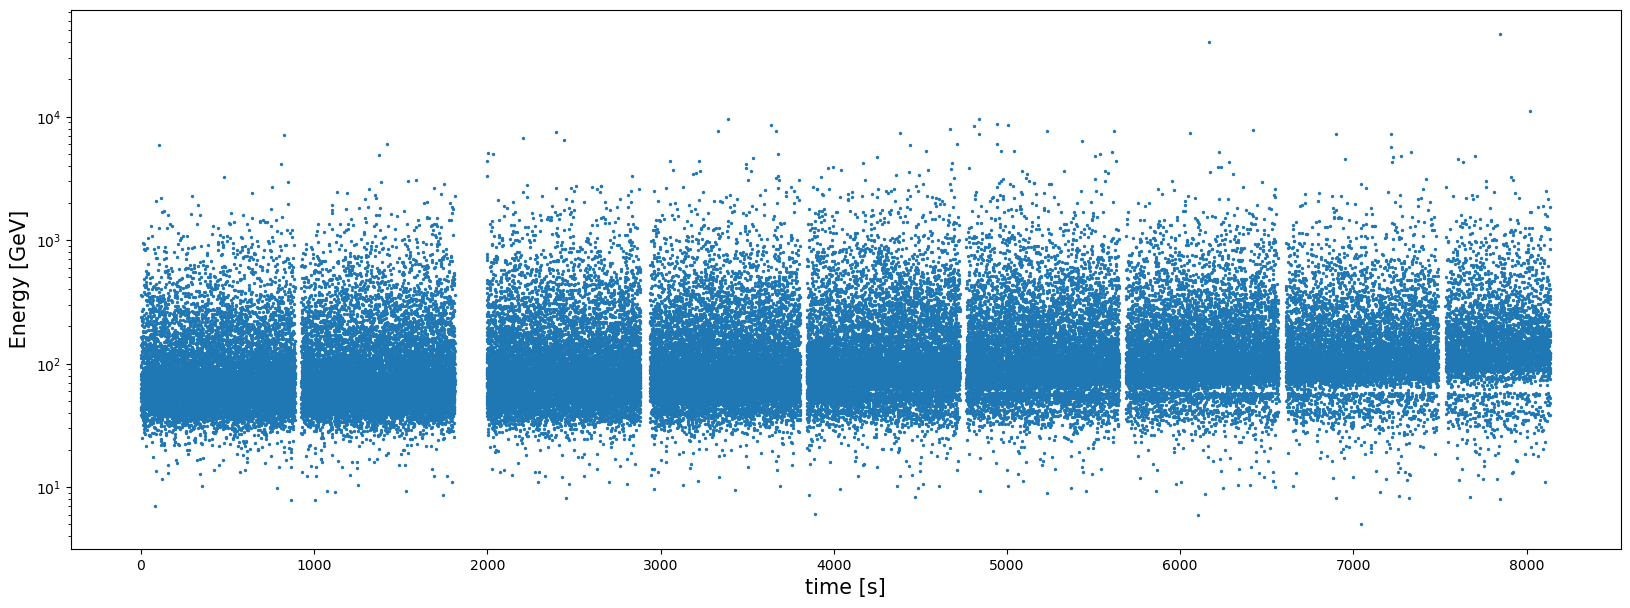

In [151]:
# PLOT ENERGY VS TIME

fig, ax = plt.subplots( 1,1,figsize=(20,7))

plt.ylabel(r' Energy [GeV] ',size=15)
plt.xlabel('time [s]',size=15)

plt.scatter( all_times, all_energies, s=2) 

plt.yscale('log')

Two time slot where there is no data -> can lead to biased results. Maybe change the code to exclude region without data ? 

 begins :  0.37215709686435616 s2 ends at : 8136.806521177289 s2


<ErrorbarContainer object of 3 artists>

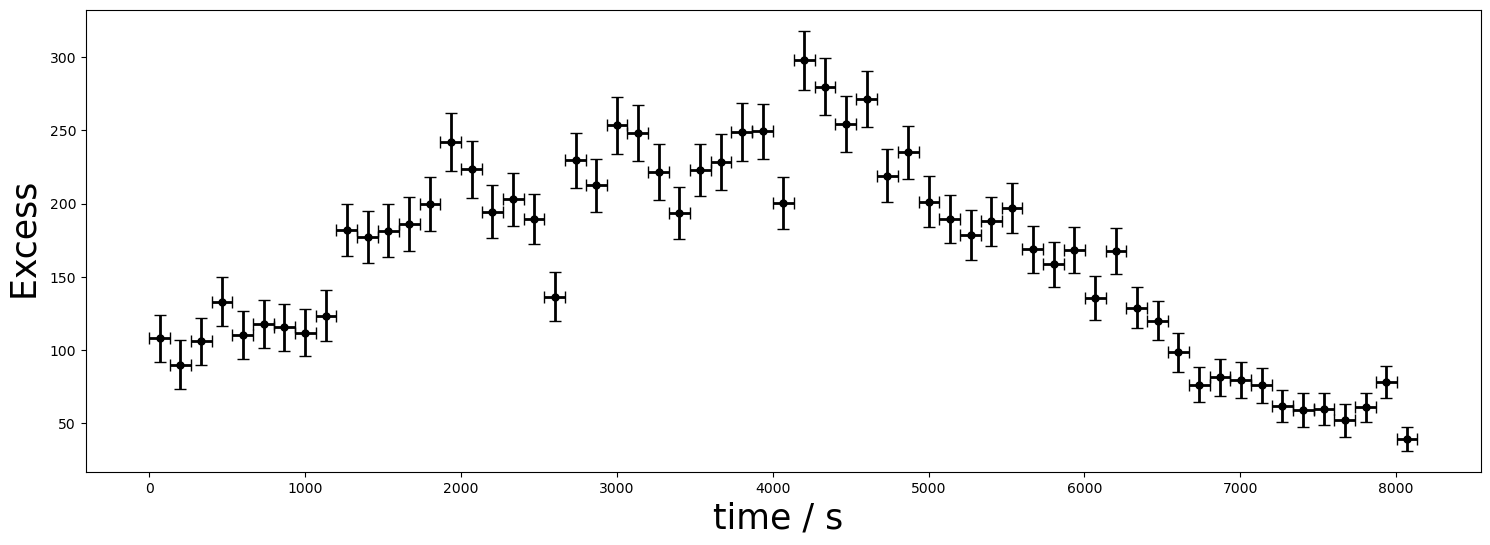

In [152]:
# PLOT LIGHT CURVE 

t_prime = np.linspace(all_times[0]*u.s, all_times[-1]*u.s, len(short_observations)+1  ) 
E_prime = np.geomspace(  30*u.GeV, 10*u.TeV, 11)
print(" begins : ", all_times[0]*u.s, "ends at :",  all_times[-1]*u.s) 
binwidth       = t_prime[1:]-t_prime[:-1]
bincenters     = (t_prime[1:]+t_prime[:-1])/2
LC_intr        = (counts_on_2d.sum(axis=1) -counts_off_2d.sum(axis=1)) 
LC_intr_unc    = np.sqrt( (counts_on_2d.sum(axis=1) + counts_off_2d.sum(axis=1)) )

rel_unc_per_time_bin = LC_intr_unc/LC_intr
rel_unc_per_time_bin[np.isnan(rel_unc_per_time_bin)] = 0

fig, ax = plt.subplots( 1,1,figsize=(18,6))

ax.set_ylabel(r' Excess ',fontsize=25)
ax.set_xlabel('time / s ',fontsize=25)
ax.errorbar(bincenters.value, LC_intr, LC_intr_unc ,binwidth.value/2,fmt='o', elinewidth=2, markersize=5, capsize=4,c='k')

In [153]:
# SAVE IN NUMPY ARRAY

np.save("results/ON_counts.npy", counts_on_2d)
np.save("results/OFF_counts.npy", counts_off_2d)

